Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [2]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization

root = './cifar100_data' #if not in lab
#root = '../datasets/cifar100'


dataset = torchvision.datasets.CIFAR100(root=root, train=True, transform=pad_totensor_transform, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR100(root=root, train=False, transform=pad_totensor_transform)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"BATCH SIZE: {batch_size}")
print(f"Tran subset len: {len(train_subset)}")
print(f"Tran loader len: {len(train_loader)}")
print(f"Test: {len(train_subset)/batch_size}")

print(f"Val subset len: {len(val_subset)}")
print(f"Val subset len: {len(val_loader)}")
print(f"Test: {len(val_subset)/batch_size}")


print(f"Test subset len: {len(test_dataset)}")
print(f"Test subset len: {len(test_loader)}")
print(f"Test: {len(test_dataset)/batch_size}")


Files already downloaded and verified
BATCH SIZE: 250
Tran subset len: 35000
Tran loader len: 140
Test: 140.0
Val subset len: 15000
Val subset len: 60
Test: 60.0
Test subset len: 10000
Test subset len: 40
Test: 40.0


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


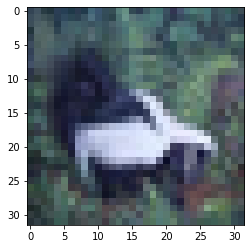

In [3]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [4]:
#device

In [5]:
#!conda install einops
from mlp_mixer import *
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import json

In [6]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted.cpu(), dim=1)
    return accuracy_score(predicted, true_labels.cpu()) #forse questi passaggi a cpu non sono molto efficienti..

def generate_folder():
    import time
    import os
    import os.path
    datetime = time.strftime("%Y%m%d-%H%M%S")

    folder = f"./models/{datetime}/"
    os.chdir(".")
    print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(folder):
        print("Exists")
    else:
        os.mkdir(folder)
    return folder

#def save_model(model, path):
#    filename = path + f"{filename}.pth"
#    print(filename)
#    torch.save(model.state_dict(), filename)    

In [7]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 32 #128 #256 #100 #512 #embed dim
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
num_layers = 5 #8
mlp_dc_dimension = 128 #512 #1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 32 #64 #128 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-5) 

num_epochs = 500
steps_total = len(train_loader)

#ATTENZIONE: CAMBIARE IPERPARAMETRI ***PRIMAAAA*** DEL DICT SUCCESSIVO

hyper_params = {
    "dataset": root,
    "comment": 'added weight decay',
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)
model_path = generate_folder()
with open(model_path+"/params.json", "w") as file:
    json.dump(hyper_params, file, indent=4)

model.to(device)
# training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_accuracy = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        predicted = model(images)
        loss = loss_func(predicted, labels)
        train_accuracy += get_accuracy(predicted, labels)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    #print(f"TRAIN LOADER LENGTH: {len(train_loader)}")
    experiment.log_metric("train epoch loss", loss.item(), step=epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step=epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        temp = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)): #numero esempi/batchsize TODO check
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, labels)
            val_accuracy += get_accuracy(predicted, labels)
        #print(f"Lenght val loader: {len(val_loader)}, counter: {temp}")
        val_accuracy /= len(val_loader) 
        experiment.log_metric("val epoch loss", loss.item(), step=epoch) #TODO average loss?
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)
    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), model_path + f"checkpoint_epch_{epoch}.pth")
torch.save(model.state_dict(), model_path + f"final.pth")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wedrid/mlp-mixer/da4a292d00c54710bcc6e21e3e000cec



current dir is: /Users/edrid/Desktop/Machine learning/Project/mlp_mixer


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 1: 4.1265


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 2: 3.7160


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 3: 3.5742


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 4: 3.4084


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 5: 3.2500


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 6: 3.0677


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 7: 3.0262


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 8: 2.8161


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 9: 2.8659


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 10: 2.7404


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 11: 2.7447


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 12: 2.4505


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 13: 2.6130


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 14: 2.7063


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 15: 2.4485


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 16: 2.3223


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 17: 2.3385


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 18: 2.3128


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 19: 2.1716


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 20: 2.2839


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 21: 2.1197


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 22: 2.0071


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 23: 2.0437


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 24: 1.9202


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 25: 2.0472


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 26: 1.9615


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 27: 1.9063


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 28: 1.8417


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 29: 1.9227


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 30: 1.8337


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 31: 1.9060


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 32: 1.8523


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 33: 1.8328


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 34: 1.6417


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 35: 1.7807


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 36: 1.6264


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 37: 1.5561


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 38: 1.5142


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 39: 1.7914


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 40: 1.7565


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 41: 1.4980


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 42: 1.4749


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 43: 1.3326


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 44: 1.3066


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 45: 1.3989


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 46: 1.4620


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 47: 1.4058


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 48: 1.3102


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 49: 1.2822


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 50: 1.2795


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 51: 1.3611


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 52: 1.2129


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 53: 1.3039


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 54: 1.3815


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 55: 1.3643


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 56: 1.2270


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 57: 1.1962


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 58: 1.3892


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 59: 1.2472


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 60: 1.0944


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 61: 1.1248


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 62: 1.0260


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 63: 1.0468


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 64: 1.1127


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 65: 0.8716


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 66: 1.0477


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 67: 1.1077


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 68: 0.9642


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 69: 1.1355


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 70: 0.9435


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 71: 1.1082


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 72: 1.0301


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 73: 1.0098


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 74: 1.0307


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 75: 0.9067


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 76: 1.1016


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 77: 0.8787


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 78: 1.0515


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 79: 1.0192


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 80: 0.8682


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 81: 0.8914


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 82: 0.6887


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 83: 0.8060


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 84: 0.8898


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 85: 0.9233


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 86: 0.7903


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 87: 0.9319


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 88: 0.8843


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 89: 0.8413


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 90: 0.7061


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 91: 0.7849


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 92: 0.8088


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 93: 0.7336


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 94: 0.7537


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 95: 0.7778


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 96: 0.9157


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 97: 0.7956


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 98: 0.6331


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 99: 0.8425


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 100: 0.7761


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
if False: 
    examples = iter(train_loader)
    images, labels = examples.next()

    # metrics trial
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = loss_func(outputs, labels)

    #da mettere nel ciclo
    print(outputs.shape)

    #####
    predicted = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(predicted, labels)
    print(f'Accuracy {accuracy}')
    #####
    print(predicted.shape)
    print(predicted)
